In [90]:
import pandas as pd
import numpy as np
from pvlib import location, irradiance, temperature, pvsystem
import matplotlib.pyplot as plt
from random import seed
from itertools import product
from sandiapv_energy_prediction import *
from scipy.integrate import trapezoid


In [91]:
def get_pv_system(panel):
    """ Retrieves and configures a PVSystem object based on the panel type and parameters. """

    module_specs = {
    'monocrystalline': {'pdc0': 220, 'gamma_pdc': -0.0045},
    'polycrystalline': {'pdc0': 200, 'gamma_pdc': -0.005},
    'thin-film': {'pdc0': 180, 'gamma_pdc': -0.002},
    'bifacial': {'pdc0': 210, 'gamma_pdc': -0.004}
    } 
    
    module_parameters = module_specs[panel['module_type']]
    mount = pvsystem.FixedMount(surface_tilt=panel['tilt'], surface_azimuth=panel['azimuth'])
    inverter_parameters = {'pdc0': 5000, 'eta_inv_nom': 0.96}
    array_one = (pvsystem.Array( mount=mount, 
                                module_parameters=module_parameters,
                                temperature_model_parameters= panel['temperature']
                                ))
    return pvsystem.PVSystem(name = 'system1',
                            arrays =array_one,
                            inverter =inverter_parameters,                           
                            )

def simulate_pv_output(system, weather_data, location):
    """ Simulate daily PV output for all arrays in the system. """
    solar_position = location.get_solarposition(weather_data.index)
    temp_air = weather_data['temp_air']
    wind_speed = weather_data['wind_speed']
    
    # Initialize an empty DataFrame to store the output for each array
    output_data = pd.DataFrame(index=weather_data.index)
    
    # Simulate output for each array in the system
    for array in system.arrays:
        poa_irrad = irradiance.get_total_irradiance(array.mount.surface_tilt, array.mount.surface_azimuth,
                                                    solar_position['apparent_zenith'], solar_position['azimuth'],
                                                    weather_data['dni'], weather_data['temp_air'], weather_data['dhi'])
        # Calculate cell temperature
        cell_temperature = temperature.sapm_cell(poa_irrad['poa_global'], temp_air, wind_speed,
                                                  **array.temperature_model_parameters)
        single_array_system = pvsystem.PVSystem(
                             name=system.name,
                            arrays=[system.arrays[0]],
                            inverter=system.inverter,)
        # Calculate DC output for the current array
        dc_output = single_array_system.pvwatts_dc(poa_irrad['poa_global'], cell_temperature)
        
        # Store the DC output in the output_data DataFrame
        output_data[array.name] = dc_output
    
    return output_data

In [92]:
weather_data =  pd.read_csv('energy_data/result.csv')

weather_data = weather_data.drop('W.mean_value',axis=1)

weather_data.index = pd.to_datetime(weather_data['time'], utc=True)
weather_data.rename(columns={'T': 'temp_air', 'FH': 'wind_speed'}, inplace=True)
print(weather_data.columns)
print(weather_data.shape)
weather_data.tail()

Index(['time', 'Q', 'temp_air', 'wind_speed', 'dni', 'dhi'], dtype='object')
(8759, 6)


,time,Q,temp_air,wind_speed,dni,dhi
time,,,,,,
2023-12-31 18:00:00+00:00,2023-12-31 18:00:00+00:00,0.0,9.6,100.0,0.0,0.0
2023-12-31 19:00:00+00:00,2023-12-31 19:00:00+00:00,0.0,8.6,80.0,0.0,0.0
2023-12-31 20:00:00+00:00,2023-12-31 20:00:00+00:00,0.0,8.4,100.0,0.0,0.0
2023-12-31 21:00:00+00:00,2023-12-31 21:00:00+00:00,0.0,8.0,90.0,0.0,0.0
2023-12-31 22:00:00+00:00,2023-12-31 22:00:00+00:00,0.0,8.6,80.0,0.0,0.0


In [93]:
def sensitivity_analysis(weather_data, altitude, tilt_range, azimuth_range, module_types,temperature_params):
    results = []
    for tilt, azimuth, module_type,temp,altitude in product(tilt_range, azimuth_range, module_types,temperature_params,altitude): 
        site_location = location.Location(latitude=52.52, longitude=13.4050, altitude=altitude, tz='Europe/Amsterdam')         
        panel = {'tilt': tilt, 'azimuth': azimuth, 'module_type': module_type,'temperature':{'a': temp[0], 'b': temp[1], 'deltaT': temp[2]} }
        system = get_pv_system(panel)
        output = simulate_pv_output(system, weather_data, site_location)
        #print(panel,output.mean().mean())
        results.append({'tilt': tilt, 'azimuth': azimuth, 'module_type': module_type,'altitude':altitude,'temperature':{'a': temp[0], 'b':temp[1], 'deltaT': temp[2]} , 'output': output.mean().mean()})
    return pd.DataFrame(results)

In [94]:
 
# Define ranges for parameters
tilt_range = np.linspace(0,90, 10)  
azimuth_range = np.linspace(0, 360, 10)  
altitude = np.linspace(1,100,10)
module_types = ['monocrystalline','polycrystalline', 'thin-film', 'bifacial']
temperature_params = [[-3.47, -0.0594, 3],[-2.98, -0.0471, 1],[-3.56, -0.075, 3],[-2.81, -0.0455, 0]]

try:
    sa_results = pd.read('energy_data/sensitivity_analysis_results.csv')
except: 
    # Perform sensitivity analysis
    sa_results = sensitivity_analysis(weather_data, altitude, tilt_range, azimuth_range, module_types,temperature_params)
    
    # Save results to CSV
    sa_results.to_csv('energy_data/sensitivity_analysis_results.csv', index=False)


In [95]:
sa_results.head()
#print('rows:',len(sa_results['tilt']))

,tilt,azimuth,module_type,altitude,temperature,output
0,0.0,0.0,monocrystalline,1.0,"{'a': -3.47, 'b': -0.0594, 'deltaT': 3}",29.197680
1,0.0,0.0,monocrystalline,12.0,"{'a': -3.47, 'b': -0.0594, 'deltaT': 3}",29.197658
2,0.0,0.0,monocrystalline,23.0,"{'a': -3.47, 'b': -0.0594, 'deltaT': 3}",29.197637
3,0.0,0.0,monocrystalline,34.0,"{'a': -3.47, 'b': -0.0594, 'deltaT': 3}",29.197615
4,0.0,0.0,monocrystalline,45.0,"{'a': -3.47, 'b': -0.0594, 'deltaT': 3}",29.197594


0    {'a': -3.47, 'b': -0.0594, 'deltaT': 3}
1    {'a': -2.98, 'b': -0.0471, 'deltaT': 1}
2     {'a': -3.56, 'b': -0.075, 'deltaT': 3}
3    {'a': -2.81, 'b': -0.0455, 'deltaT': 0}
Name: temperature, dtype: object


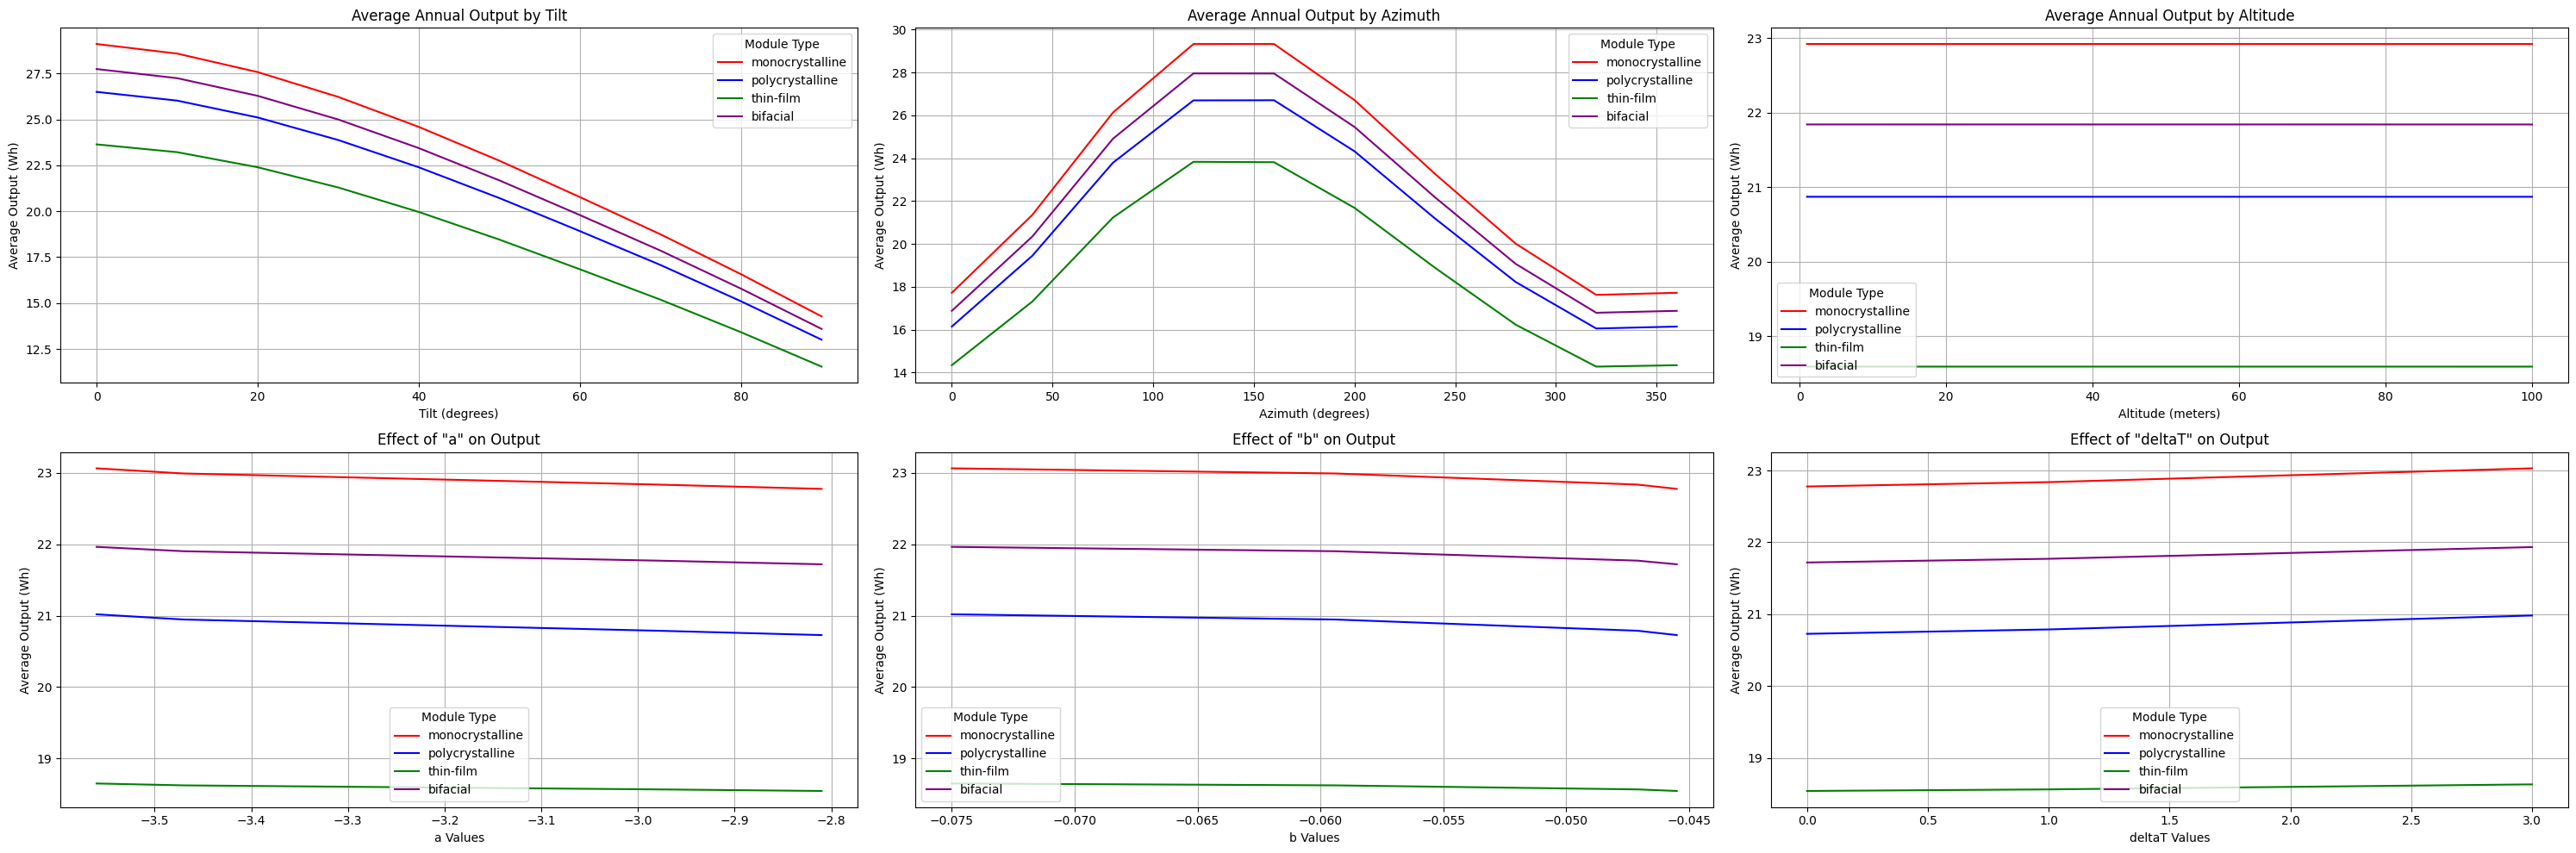

In [96]:
# Assume 'sa_results' is your DataFrame containing the results of the sensitivity analysis
module_types = ['monocrystalline', 'polycrystalline', 'thin-film', 'bifacial']
colors = ['red', 'blue', 'green', 'purple']  #

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 10))

# Tilt Effects Plot
for color, module_type in zip(colors, module_types):
    filtered_data = sa_results[sa_results['module_type'] == module_type]
    tilt_agg = filtered_data.groupby('tilt')['output'].mean()
    axes[0,0].plot(tilt_agg.index, tilt_agg.values, label=f'{module_type}', color=color)
axes[0,0].set_title('Average Annual Output by Tilt')
axes[0,0].set_xlabel('Tilt (degrees)')
axes[0,0].set_ylabel('Average Output (Wh)')
axes[0,0].legend(title='Module Type')
axes[0,0].grid(True)

# Azimuth Effects Plot
for color, module_type in zip(colors, module_types):
    filtered_data = sa_results[sa_results['module_type'] == module_type]
    azimuth_agg = filtered_data.groupby('azimuth')['output'].mean()
    axes[0,1].plot(azimuth_agg.index, azimuth_agg.values, label=f'{module_type}', color=color)
axes[0,1].set_title('Average Annual Output by Azimuth')
axes[0,1].set_xlabel('Azimuth (degrees)')
axes[0,1].set_ylabel('Average Output (Wh)')
axes[0,1].legend(title='Module Type')
axes[0,1].grid(True)

# Empty third column in the first row
# Azimuth Effects Plot
for color, module_type in zip(colors, module_types):
    filtered_data = sa_results[sa_results['module_type'] == module_type]
    azimuth_agg = filtered_data.groupby('altitude')['output'].mean()
    axes[0,2].plot(azimuth_agg.index, azimuth_agg.values, label=f'{module_type}', color=color)
axes[0,2].set_title('Average Annual Output by Altitude')
axes[0,2].set_xlabel('Altitude (meters)')
axes[0,2].set_ylabel('Average Output (Wh)')
axes[0,2].legend(title='Module Type')
axes[0,2].grid(True)

# Temperature Effects Plot, now in the second row
temp_params = sa_results['temperature'].drop_duplicates().reset_index(drop=True)
temp_colors = ['red', 'blue', 'green', 'purple'][:len(temp_params)]
print(temp_params)


temp_df = sa_results['temperature'].apply(pd.Series)
sa_results_expanded = pd.concat([sa_results, temp_df], axis=1)

# Plotting the effects of each temperature parameter 'a', 'b', 'deltaT'
parameters = ['a', 'b', 'deltaT']
titles = ['Effect of "a" on Output', 'Effect of "b" on Output', 'Effect of "deltaT" on Output']
x_labels = ['a Values', 'b Values', 'deltaT Values']

for i, param in enumerate(parameters):
    for color, module_type in zip(colors, module_types):
        # Filter data for each module type and aggregate by parameter
        filtered_data = sa_results_expanded[sa_results_expanded['module_type'] == module_type]
        param_agg = filtered_data.groupby(param)['output'].mean()
        
        axes[1,i].plot(param_agg.index, param_agg.values, label=f'{module_type}', color=color)
        axes[1,i].set_title(titles[i])
        axes[1,i].set_xlabel(x_labels[i])
        axes[1,i].set_ylabel('Average Output (Wh)')
        axes[1,i].legend(title='Module Type')
        axes[1,i].grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

## 2) Generate Dataset

In [99]:
# Define the Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Function to fit Gaussian to daily data
def fit_gaussian_to_daily_data(hourly_data):
    x_numeric = np.arange(len(hourly_data))
    #print(hourly_data.values)
    #hourly_data = hourly_data.values
    #print(hourly_data)
    #print(hourly_data)
    try:
        # Improved initial guesses and increase maxfev
        p0 = [max(hourly_data), np.argmax(hourly_data), len(hourly_data) / 2]  # Better estimate of std deviation
        popt, _ = curve_fit(gaussian, x_numeric, hourly_data, p0=p0, maxfev=1000)
    except Exception as e:
        #print(f"Error in Gaussian fit: {e}")
        popt = None
    return popt



In [108]:
def generate_dataset(weather_data, site_location, tilt_range, azimuth_range, module_types,temperature_params):
    results = []
    delta_AUC = []
    counter = 0
    iteration =0 
    for tilt, azimuth, module_type in product(tilt_range, azimuth_range, module_types):          
        panel = {'tilt': tilt, 'azimuth': azimuth, 'module_type': module_type,'temperature':{'a': temperature_params[0], 'b': temperature_params[1], 'deltaT': temperature_params[2]} }
        system = get_pv_system(panel)
        output = simulate_pv_output(system, weather_data, site_location)
        counter += 1 
        print(counter)
        
        #if counter > 1: 
        #    break
        for day in range(10):
            iteration +=1
            #print(iteration)
            start_idx = day * 24
            end_idx = (day + 1) * 24

            daily_data = output.iloc[start_idx:end_idx]
            daily_weather_data = weather_data.iloc[start_idx:end_idx]
            
            popt = fit_gaussian_to_daily_data(daily_data.values.flatten())
            #print(popt)
            if popt is not None:
                x_dense = np.linspace(0, 23, 500)  
                gaussian_curve = gaussian(x_dense, *popt)
                
                # Calculate the area under the Gaussian curve
                area_gaussian = trapezoid(gaussian_curve, dx=x_dense[1]-x_dense[0])

                # Calculate the area under the original daily mean data
                area_original = trapezoid(daily_data, dx=1) 
                delta_AUC.append(area_original/area_gaussian)

                #Extracting hourly weather data lists
                daily_weather = {
                'temperature_sequence': list(daily_weather_data['temp_air']),
                'wind_speed_sequence': list(daily_weather_data['wind_speed']),
                'dni_sequence': list(daily_weather_data['dni']),
                'dhi_sequence': list(daily_weather_data['dhi']),
                'global_irradiance_sequence': list(daily_weather_data['Q'])
                 }
                results.append({
                    'module_type': module_type,
                    'tilt': tilt,
                    'azimuth': azimuth,
                    'gaussian_params': popt,
                    **daily_weather,

                })
    #print(np.mean(delta_AUC.flatten()))
    return pd.DataFrame(results)

# Define ranges for parameters
tilt_range = np.linspace(0, 360, 10)  
azimuth_range = np.linspace(0, 360, 10)  
module_types = ['monocrystalline','polycrystalline',] #'thin-film', 'bifacial']
temperature_params = [-2.81, -0.0455, 0] #glass/polymer, Insulated Back
site_location = location.Location(latitude=51.44, longitude=5.47, altitude=34, tz='Europe/Amsterdam')

# Perform sensitivity analysis
sa_results = generate_dataset(weather_data, site_location, tilt_range, azimuth_range, module_types,temperature_params)
    
# Save results to CSV
sa_results.to_csv('energy_data/dataset_to_train_model.csv', index=False)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


## 3) Plot dataset to verify 

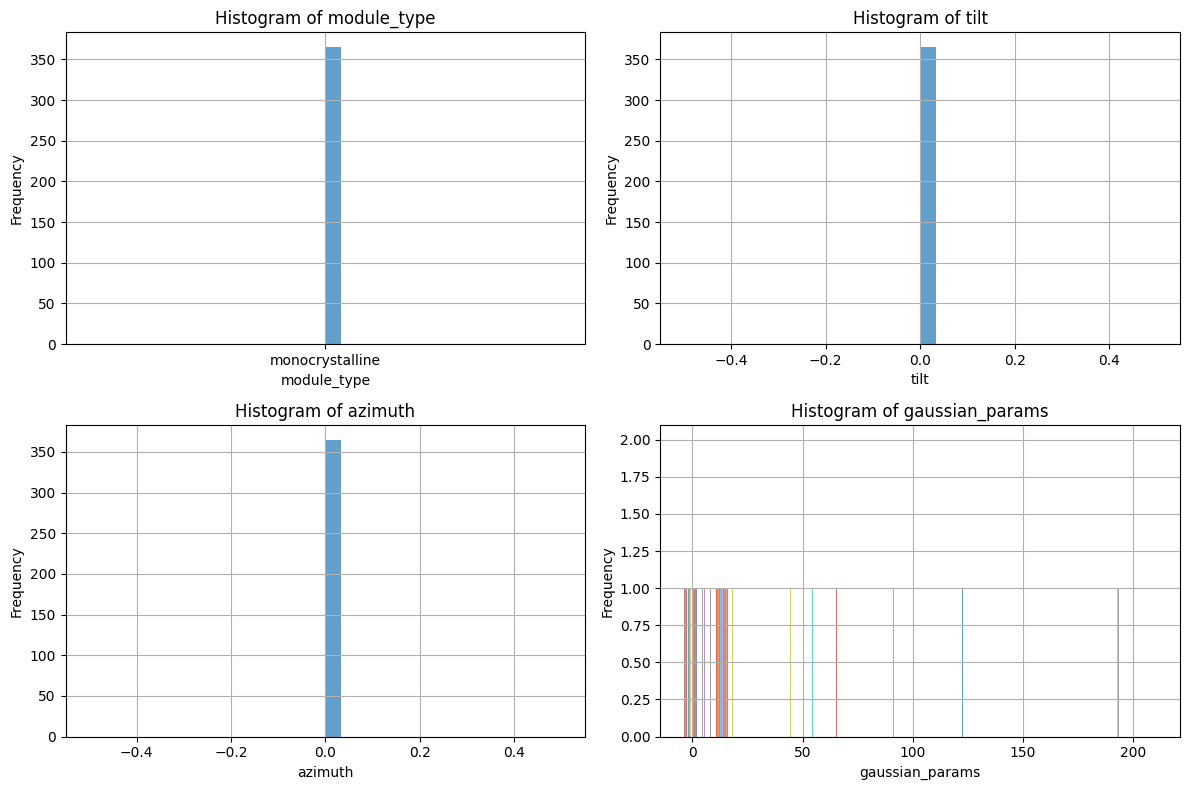

In [107]:
columns =[ 'module_type','tilt','azimuth','gaussian_params']
num_columns = len(columns)
num_rows = (num_columns + 1) // 2  

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 4))  
axes = axes.flatten()  

for i, column in enumerate(columns):
    sa_results[column].hist(ax=axes[i], bins=30, alpha=0.7)  
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# If the number of columns is odd, hide the last subplot (if unused)
if num_columns % 2 != 0:
    fig.delaxes(axes[-1])

fig.tight_layout()
plt.show()